contour level [ 0.5]
number of contour path 1
contour level [ 0.5]
number of contour path 1
contour level [ 0.5]
number of contour path 2


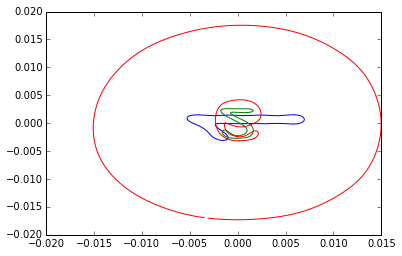

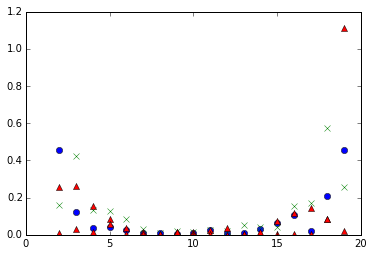

In [119]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
import pdb

def extract_shape(im_file, blowup=1., plot_img=False, plot_contour=False, plot_contour_pts=False):
    im = mpimg.imread(im_file)
    # Take one of RGB(A) channels
    if len(im.shape) > 2:
        im = im[:, :, 0]
    
    if plot_img:
        plt.figure()
        plt.title('Original Shape')
        plt.imshow(im, cmap = plt.cm.gray)

    # Note: by convention, in this case, y values comes from the 0th index.
    # Otherwise one has to transpose the image and the contour will appear sideways 
    x = np.arange(im.shape[1])*blowup  
    y = np.arange(im.shape[0])*blowup
    
    # Have to flip y to get the orientation right, again just a peculiar convention we have to work around
    # Note the [::] notation: a[3:20:2] means from the 3rd element to the 20th element, choose every 2nd element.
    x = x[::1]

    # In case I want to shift x.
    #x_shift = 200
    #x += x_shift

    X, Y = np.meshgrid(x, y)
    
    plt.figure()
    plt.title('Contours')
    # Note the dimensions of x and y may NOT the same, thus the necessity of the 
    # tranpose operation (an oddity, I admit...)
    CS = plt.contour(X, Y, im, 1)
    levels = CS.levels
    print 'contour level', levels
    if not plot_contour:
        plt.close()

    cs_paths = CS.collections[0].get_paths()

    print 'number of contour path', len(cs_paths)

    x_arr = []
    y_arr = []
    for i in range(len(cs_paths)):
        p = cs_paths[i]
        v = p.vertices
        x_arr.append(v[:,0])
        y_arr.append(v[:,1])

    if plot_contour_pts:
        plt.figure()
        plt.title("Verify the contour points are correct")
        for i in range(len(x_arr)):
            plt.scatter(x_arr[i], y_arr[i])

    return x_arr, y_arr

def FD(x, y, plot_FD=False, y_lim=None):
    N = len(x)    # Total number of points.
    n = np.arange(N)    # points up until N-1.
    z = x + y*1j
    Z = np.fft.fft(z)    # Fourier transform of lowercase z.
    if plot_FD is True:
        plt.figure()
        plt.title('FD real and imag')
        plt.plot(Z.real, 'b-')
        plt.plot(Z.imag, 'g-')
        if y_lim != None:
            plt.ylim([-y_lim, y_lim])
    return Z
     
def filt_FD(Z, n_keep, no_zeroth=True):
    N = len(Z)
    n = np.arange(len(Z))
    zeroth = 1
    if no_zeroth:
        zeroth = n > 0
    # low freq: low n terms
    filt1 = zeroth*(n <= n_keep)
    # low freq: high n terms
    filt2 = (n > ((N-1) - n_keep))
    # low freq: both low and high n terms   
    filt = filt1 + filt2
    
    Z *= filt
    return Z

def get_FD_abs(x, y, order=10, norm=True, no_zeroth=True):
    x_reco = []
    y_reco = []
    fd_magn = []
    for i in range(len(x)):
        Z = FD(x[i], y[i])
        Z_filt = filt_FD(Z, order, no_zeroth)
        if norm:
            Z_filt = size_norm(Z_filt)
        x_rec, y_rec = recover_shape(Z_filt)
        tmp_mag = []
        for i in Z_filt:
            if i != 0:
                tmp_mag.append(i)
        fd_mag = np.abs(tmp_mag)
        x_reco.append(x_rec)
        y_reco.append(y_rec)
        fd_magn.append(fd_mag)
    return fd_magn, x_reco, y_reco

def recover_shape(Z):
    z_rec = np.fft.ifft(Z)
    x_rec = z_rec.real
    y_rec = z_rec.imag
    return x_rec, y_rec

def size_norm(Z):
    return Z/np.sqrt(np.abs(Z[1])*np.abs(Z[-1]))

####################################################################################################

##################
## Main Program ##
##################

x1, y1 = extract_shape('number1.png')
x2, y2 = extract_shape('number2.png')
x6, y6 = extract_shape('number6.png')

fd1_mag, x1_rec, y1_rec = get_FD_abs(x1, y1)
fd2_mag, x2_rec, y2_rec = get_FD_abs(x2, y2)
fd6_mag, x6_rec, y6_rec = get_FD_abs(x6, y6)

plt.figure()
for i in range(len(x1_rec)):
    plt.plot(y1_rec[i], x1_rec[i], 'b')
for i in range(len(x2_rec)):
    plt.plot(x2_rec[i], y2_rec[i], 'g')
for i in range(len(x6_rec)):
    plt.plot(x6_rec[i], y6_rec[i], 'r')
plt.savefig('rec_numbers126.pdf')
plt.show()

plt.figure()
plt.xlim(0, 2*10)
for i in range(len(fd1_mag)):
    plt.plot(np.arange(2, 2*10), fd1_mag[i][1:-1], 'bo')
for i in range(len(fd2_mag)):
    plt.plot(np.arange(2, 2*10), fd2_mag[i][1:-1], 'gx')
for i in range(len(fd6_mag)):
    plt.plot(np.arange(2, 2*10), fd6_mag[i][1:-1], 'r^')
plt.savefig('FourierDescriptor_numbers126.pdf')
plt.show()